# Описание проекта

### Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

#### Описание данных:

* #### Name — название игры

* #### Platform — платформа

* #### Year_of_Release — год выпуска

* #### Genre — жанр игры

* #### NA_sales — продажи в Северной Америке (миллионы долларов)

* #### EU_sales — продажи в Европе (миллионы долларов)

* #### JP_sales — продажи в Японии (миллионы долларов)

* #### Other_sales — продажи в других странах (миллионы долларов)

* #### Critic_Score — оценка критиков (максимум 100)

* #### User_Score — оценка пользователей (максимум 10)

* #### Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Шаг 1. Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

df = pd.read_csv('/datasets/games.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


#### При ознакомлении с датафреймом бросаются в глаза огромное количество пропусков, неудобные названия столбцов и неверный тип данных в столбцах Year_of_Release, User_Score и Critic_Score

## Шаг 2. Подготовка данных

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
df['user_score'] = pd.to_numeric(df['user_score'], errors = 'coerce') #при преобразовании типа данных заодно избавились от tbd - эти значения станут пустыми
df['year_of_release'] = df['year_of_release'].astype('Int64')
df['critic_score'] = df['critic_score'].astype('Int64')
df.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         Int64
user_score         float64
rating              object
dtype: object

#### В столбце user_score строковый тип данных был переведн в плавающий тип данных для возможности проведения математических операций над столбцом. 
#### В столбце year_of_release плавающий тип данных был переведен в целочисленный для избавления от знаков после запятой. 

### Обработка пропусков:

In [6]:
df.isna().mean() 

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.545917
rating             0.404786
dtype: float64

#### В датафрейме имеется огромное количество пропусков в столбцах с рейтингом и оценками. В остальных столбцах пропуски либо не имеются, либо имеются в очень малом количестве. Данные столбцы проигнорируем. 

#### Пропущенное значение оценки определенной игры заполняется средним значением оценок этой же игры по "соседним" платформам. 
#### Возрастной рейтинг будет заполняться тем же значением, что и на другой платформе. 
#### Ниже будет демонстрация заполнения пропуска на примере данных по игре Call of Duty: Ghosts. 

In [7]:
df[df['name'] == 'Call of Duty: Ghosts'][['name', 'platform','critic_score', 'user_score', 'rating']] ### замечаем строку с пропуском

,name,platform,critic_score,user_score,rating
60,Call of Duty: Ghosts,X360,73,2.6,M
69,Call of Duty: Ghosts,PS3,71,2.6,M
323,Call of Duty: Ghosts,PS4,78,3.7,M
493,Call of Duty: Ghosts,XOne,78,4.3,M
2916,Call of Duty: Ghosts,PC,NaN,NaN,NaN
5348,Call of Duty: Ghosts,WiiU,69,3.4,M


In [8]:
df['rating'] = df['rating'].replace('K-A', 'E') # Рейтинга 'K-A' не существует, вместо него появился рейтинг 'E'
df['critic_score'] = df['critic_score'].fillna(-100000) # все пропущенные значения заполним числом, которое точно не встречается в датасете
df['user_score'] = df['user_score'].fillna(-100000) # далее эти значения будем заменять на средние. 
df['rating'] = df['rating'].fillna('')   

In [9]:
df[df['name'] == 'Call of Duty: Ghosts'][['name', 'platform','critic_score', 'user_score', 'rating']]

,name,platform,critic_score,user_score,rating
60,Call of Duty: Ghosts,X360,73,2.6,M
69,Call of Duty: Ghosts,PS3,71,2.6,M
323,Call of Duty: Ghosts,PS4,78,3.7,M
493,Call of Duty: Ghosts,XOne,78,4.3,M
2916,Call of Duty: Ghosts,PC,-100000,-100000.0,
5348,Call of Duty: Ghosts,WiiU,69,3.4,M


In [10]:
def fill_criticscore(row):
    critic_score = row['critic_score']
    if critic_score == -100000: 
        platform = row['platform']
        name = row['name'] 
        value = df[(df['platform'] != platform) & (df['name'] == name) & (df['critic_score'] > 0)]['critic_score'].mean()
        return value
    else: 
        return critic_score

In [11]:
def fill_userscore(row):
    user_score = row['user_score']
    if user_score == -100000: 
        platform = row['platform']
        name = row['name']
        value = df[(df['platform'] != platform) & (df['name'] == name) & (df['user_score'] > 0)]['user_score'].mean()
        return value
    else: 
        return user_score

In [12]:
def fill_rating(row):
    rating = row['rating']
    if rating == '':
        try:
            platform = row['platform']
            name = row['name']
            value = df[(df['platform'] != platform) & (df['name'] == name)]['rating'].values[0]
            return value
        except: 
            return rating
    else: 
        return rating

In [13]:
df['critic_score'] = df.apply(fill_criticscore, axis=1)
df['user_score'] = df.apply(fill_userscore, axis=1)
df['rating'] = df.apply(fill_rating, axis=1)

In [14]:
df[df['name'] == 'Call of Duty: Ghosts'][['name', 'platform','critic_score', 'user_score', 'rating']]

,name,platform,critic_score,user_score,rating
60,Call of Duty: Ghosts,X360,73.0,2.60,M
69,Call of Duty: Ghosts,PS3,71.0,2.60,M
323,Call of Duty: Ghosts,PS4,78.0,3.70,M
493,Call of Duty: Ghosts,XOne,78.0,4.30,M
2916,Call of Duty: Ghosts,PC,73.8,3.32,M
5348,Call of Duty: Ghosts,WiiU,69.0,3.40,M


In [15]:
df['rating'].value_counts()

        6390
E       4122
T       3088
M       1635
E10+    1466
EC        10
RP         3
AO         1
Name: rating, dtype: int64

In [16]:
df['rating'] = df['rating'].replace('', np.nan) #пустые значения nan, от которых не удалось избавиться, обратно заменим на пустые. 
df['rating'].value_counts()

E       4122
T       3088
M       1635
E10+    1466
EC        10
RP         3
AO         1
Name: rating, dtype: int64

In [17]:
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.455698
user_score         0.480168
rating             0.382291
dtype: float64

#### После обработки пропусков удалось заполнить малую часть данных. Все данные не могли быть заполнены по причине того, что данные по многим играм имеются лишь по одной платформе.
#### Данные получены из открытых источников - возможно именно с этим связано большое количество пропусков.  
#### До этапа обработки пропусков значения 'tbd' в user_score были заменены на пустые в результате преобразования типа данных в столбце. Возможно некоторые из этих значений при обработке пропусков заполнились. 

### Подсчет суммарных продаж во всех регионах

In [18]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12691,CMT Presents: Karaoke Revolution Country,PS2,2006,Misc,0.03,0.02,0.00,0.01,71.0,NaN,E10+,0.06
14151,Gekiatsu!! Pachi Game Tamashi: CR Evangelion -...,PS3,2010,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03
9266,Hot Wheels: World Race,GBA,2003,Racing,0.10,0.04,0.00,0.00,NaN,6.2,E,0.14
16457,Monster Bomber,DS,2006,Puzzle,0.01,0.00,0.00,0.00,55.0,NaN,E,0.01
996,Sonic the Hedgehog 3,GEN,1994,Platform,1.02,0.47,0.20,0.07,NaN,NaN,NaN,1.76


## Шаг 3. Исследовательский анализ данных

In [19]:
df['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64

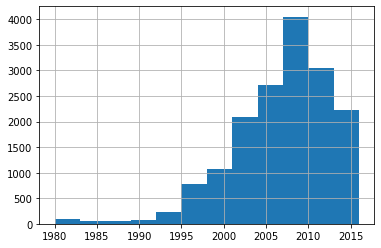

In [20]:
df['year_of_release'].hist(bins = 12)

#### Период данных достаточно больной: он представлен с 1980 по 2016 год. Очевидно, что данные старых лет не несут в себе ценности и только будут искажать информацию при составлении прогноза на 2017 год

In [21]:
overall_top = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by='total_sales', ascending = False).reset_index()
overall_top.head(7)

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85


In [22]:
def platform_hist(row):
    for name in row['platform']:
        df[df['platform'] == name]['year_of_release'].hist()
        plt.xlabel('Годы')
        plt.ylabel('Количество наблюдений')
        plt.title('Гистограмма количества проданных игр на платформе {}'.format(name))
        plt.show()

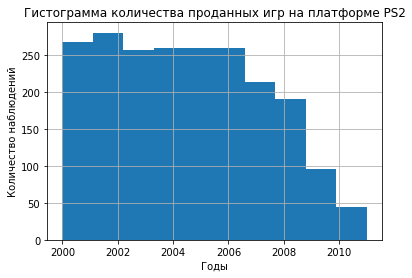

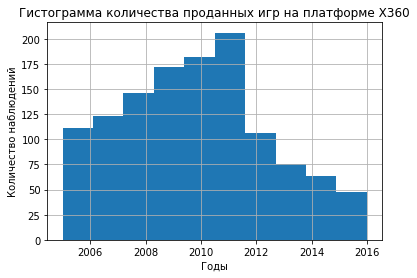

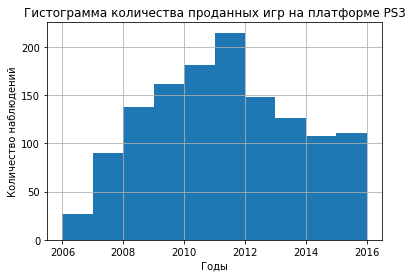

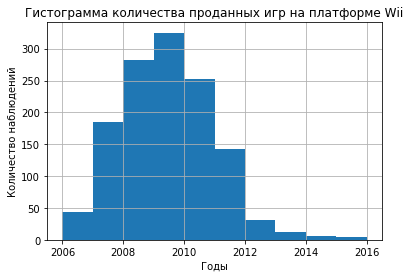

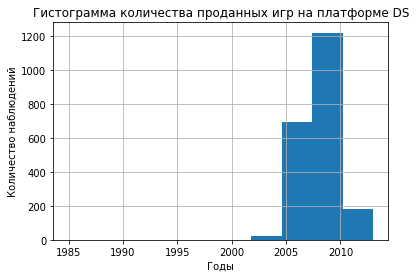

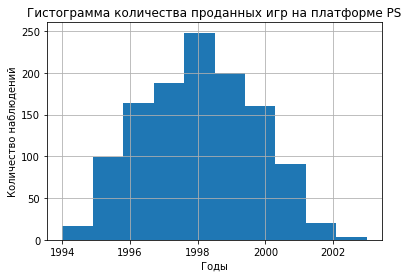

In [23]:
platform_hist(overall_top.head(6))

#### Платформы исчезают примерно за 8-10 лет, при этом спад в количестве продаж их игр наблюдается после 5 лет с момента появления платформы в связи с появлением новых платформ 

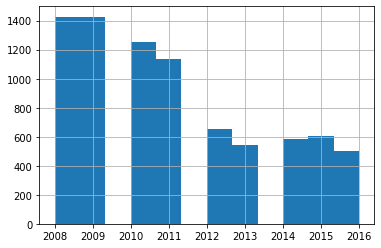

In [24]:
df[df['year_of_release'] >= 2008]['year_of_release'].hist(bins = 12)

In [25]:
actual_df = df[(df['year_of_release'] >= 2012) & (df['year_of_release'] < 2016)]
actual_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


#### За актуальный период возьмем данные с 2012 по 2015 года. Наблюдаемый тренд в спаде количества проданных игр прекращается в 2012 году и с этого момента количество проданных игр примерно неизменно. 2016 год не будет включен в период, так как данные по этому году неполные и будут искажать данные. 

### Выбор  потенциально прибыльных платформ:

In [26]:
total_sales = actual_df.pivot_table(index = 'year_of_release', values='total_sales', aggfunc ='sum', columns = 'platform')
total_sales

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14


In [27]:
total_sales.sum().sort_values(ascending=False).head()

platform
PS3     285.19
PS4     244.89
X360    235.02
3DS     179.47
XOne    133.17
dtype: float64

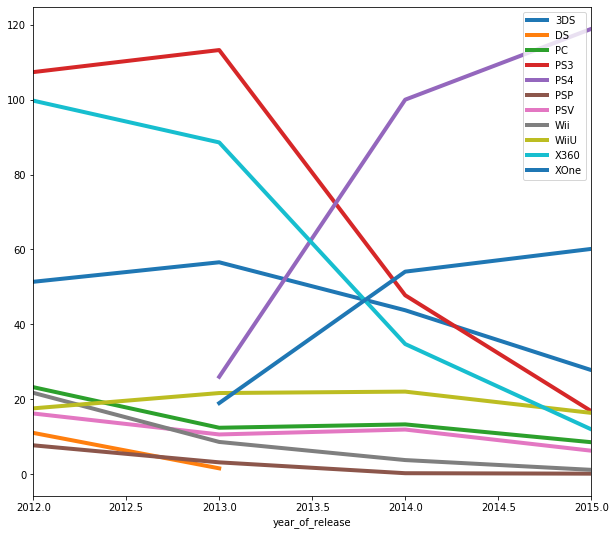

In [28]:
total_sales.plot.line(figsize = (10,9), linewidth = 4)
plt.legend(loc=0)

#### Замечаем рост лишь двух платформ. Рассмотрим динамику продаж каждой платформы по отдельности.

In [29]:
def platform_line(row):
    for name in row['platform'].unique():
        row[row['platform'] == name].plot.line(x = 'year_of_release', y = 'total_sales', linewidth = 3)
        plt.xlabel('Годы')
        plt.ylabel('Продажи, млн долларов')
        plt.title('Динамика продаж игр платформы {}, млн долл.'.format(name))
        plt.show()

In [30]:
grouped = actual_df.groupby(by = ['platform', 'year_of_release']).agg({'total_sales': 'sum'}).reset_index()
grouped

,platform,year_of_release,total_sales
0,3DS,2012,51.36
1,3DS,2013,56.57
2,3DS,2014,43.76
3,3DS,2015,27.78
4,DS,2012,11.01
5,DS,2013,1.54
6,PC,2012,23.22
7,PC,2013,12.38
8,PC,2014,13.28
9,PC,2015,8.52


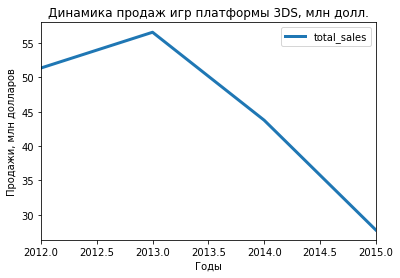

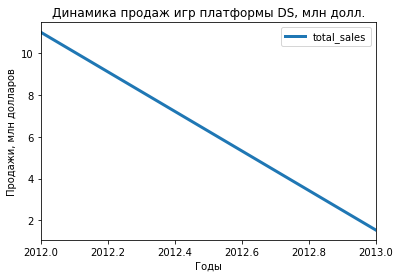

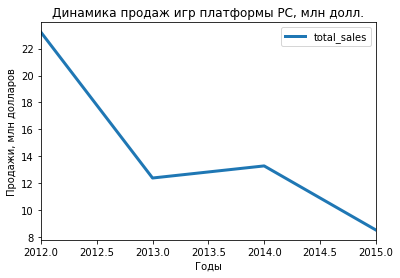

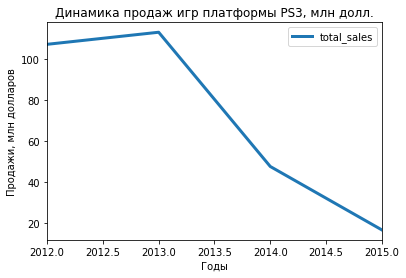

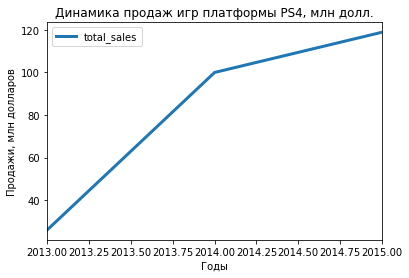

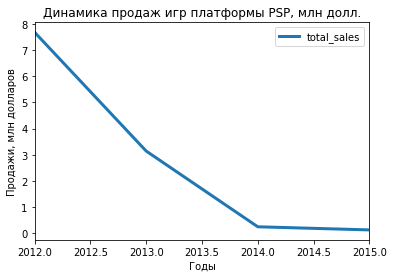

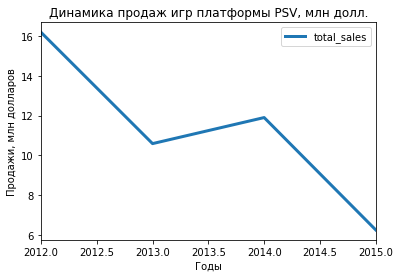

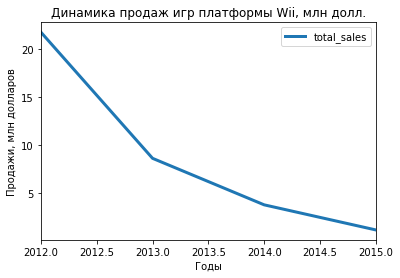

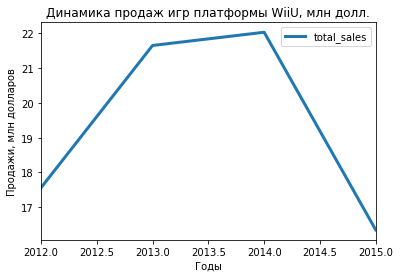

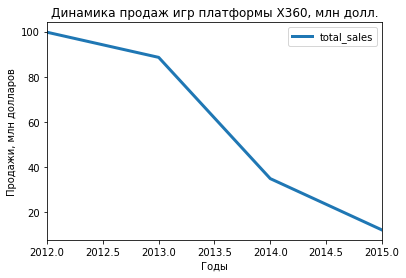

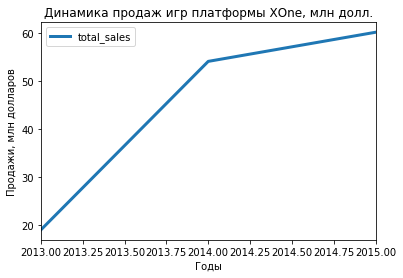

In [31]:
platform_line(grouped)

#### Лидерами по продажам за выбранный период являются платформы PS3, PS4, X360, 3DS, XOne.
#### Тем не менее, перспективными считаются только две платформы: PS4 и XOne, так как только у этих платформ наблюдается восходящий тренд. Можно отметить, что PS4 и XOne являются преемниками платформ PS3 и X360, по этой причине потенциал их роста еще выше, так как появились они на рынке позже других платформ но уже выбились в лидеры. 
#### Все остальные платформы имеют относительно маленькую долю рынка и падают по продажам. 
---------------------------

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


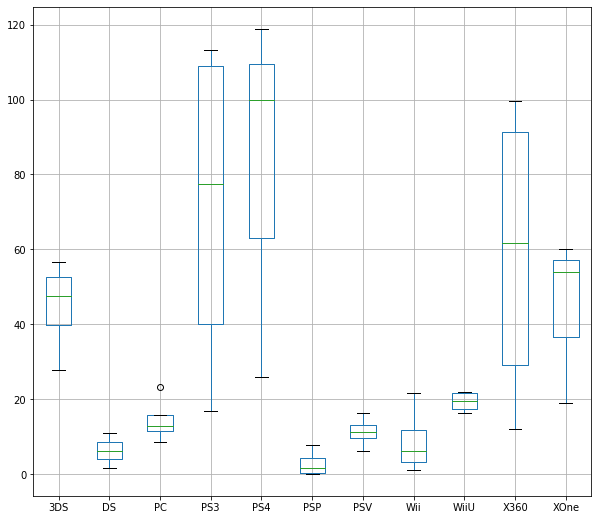

In [32]:
total_sales.boxplot(figsize = (10,9))

#### Как видно из графика выше, продажи платформ PS3, PS4 и X360 на голову выше продаж остальных платформ   

### Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков:

Коэффициент корреляции между оценками пользователей и продажами на платформе PS4 0.02


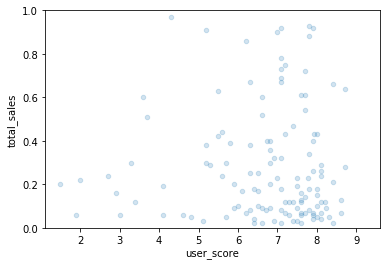

In [33]:
print('Коэффициент корреляции между оценками пользователей и продажами на платформе PS4', 
      actual_df[actual_df['platform'] == 'PS4']['user_score'].
      corr(actual_df[actual_df['platform'] == 'PS4']['total_sales']).round(2))
actual_df[actual_df['platform'] == 'PS4'].plot(x='user_score', y='total_sales', kind='scatter', alpha = 0.2, ylim = (0,1))

Коэффициент корреляции между оценками критиков и продажами 0.41


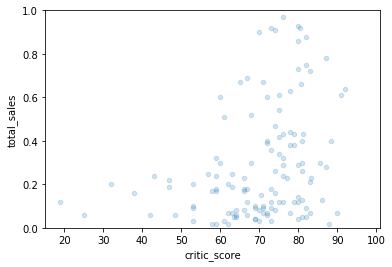

In [34]:
print('Коэффициент корреляции между оценками критиков и продажами', 
      actual_df[actual_df['platform'] == 'PS4']['critic_score'].
      corr(actual_df[actual_df['platform'] == 'PS4']['total_sales']).round(2))
actual_df[actual_df['platform'] == 'PS4'].plot(x='critic_score', y='total_sales', kind='scatter', alpha = 0.2, ylim = (0,1))

#### Коэффициенты корреляции между оценками и продажами низок по платформе PS4. Тем не менее, по точечным диаграммам заметно, что высокие значения продаж наблюдаются лишь у игр с высокими оценками, то есть связь присутствует, несмотря на значения коэффициентов корреляций

### Соотношение выводов с продажами игр на других платформах:

In [35]:
def platform_scatterplot(row):
    for name in row['platform'].unique():
        print('\033[1m' + name)
        row[row['platform'] == name].plot(x='critic_score', y='total_sales', kind='scatter', alpha = 0.3, ylim = (0,1))
        plt.title('График зависимости между отзывами критиков и общими продажами на платформе {}'.format(name))
        plt.show()
        print()
        print('Коэффициент корреляции =', row[row['platform'] == name]['critic_score'].corr(row[row['platform'] == name]['total_sales']).round(2))
        print()
        row[row['platform'] == name].plot(x='user_score', y='total_sales', kind='scatter', alpha = 0.3, ylim = (0,1))
        plt.title('График зависимости между отзывами пользователей и общими продажами на платформе {}'.format(name))
        plt.show()
        print()
        print('Коэффициент корреляции =', row[row['platform'] == name]['user_score'].corr(row[row['platform'] == name]['total_sales']).round(2))
        print('----------------------------------')

PS3


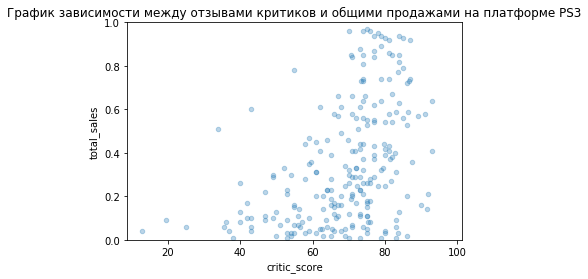


Коэффициент корреляции = 0.32



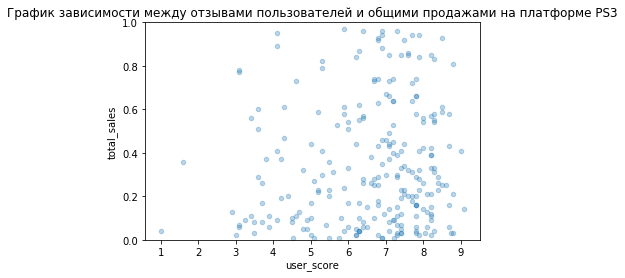


Коэффициент корреляции = -0.0
----------------------------------
X360


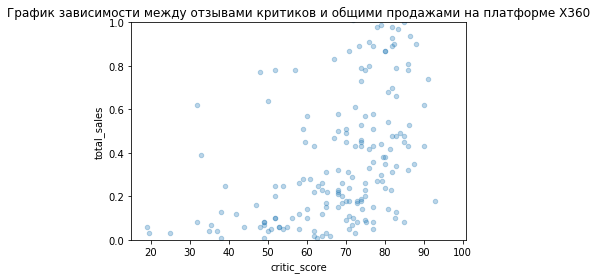


Коэффициент корреляции = 0.34



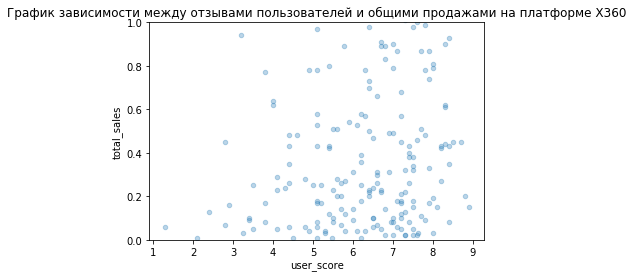


Коэффициент корреляции = -0.0
----------------------------------
PS4


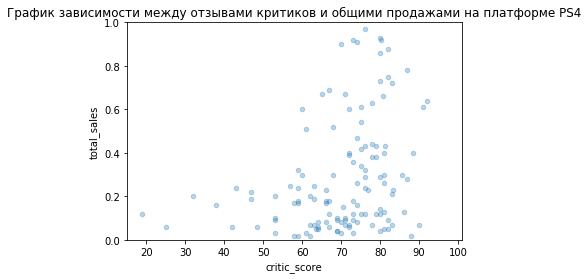


Коэффициент корреляции = 0.41



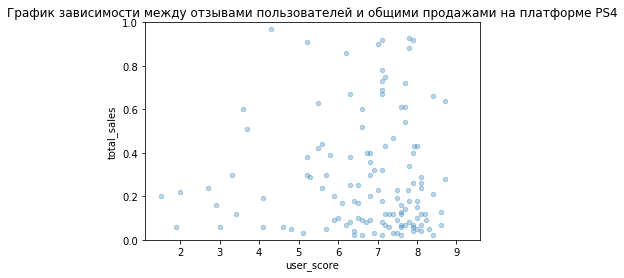


Коэффициент корреляции = 0.02
----------------------------------
3DS


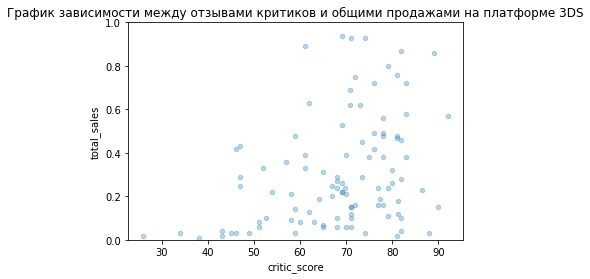


Коэффициент корреляции = 0.3



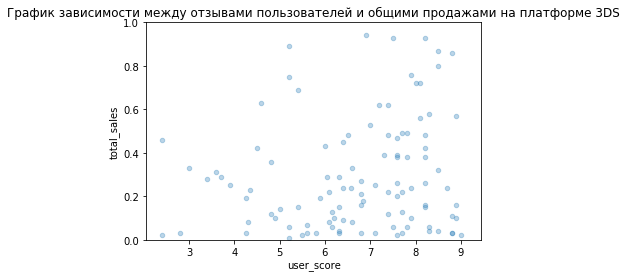


Коэффициент корреляции = 0.23
----------------------------------
DS


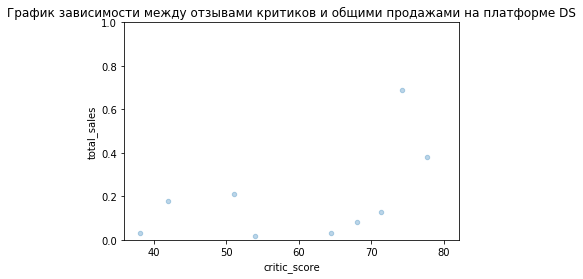


Коэффициент корреляции = 0.61



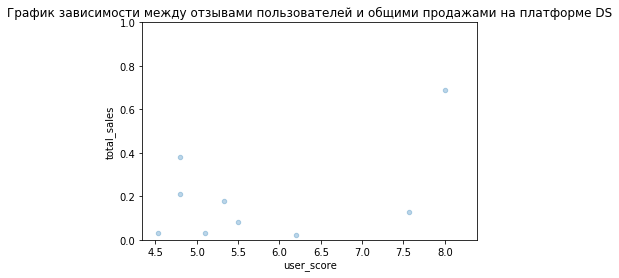


Коэффициент корреляции = 0.68
----------------------------------
XOne


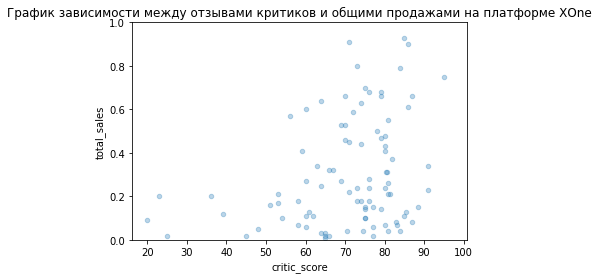


Коэффициент корреляции = 0.39



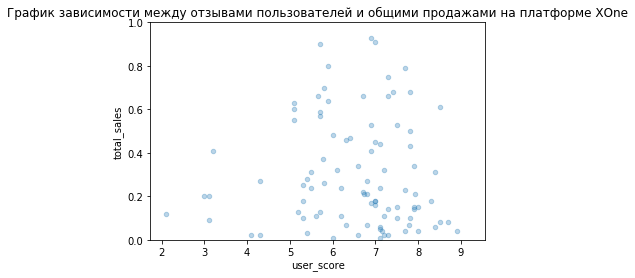


Коэффициент корреляции = -0.07
----------------------------------
WiiU


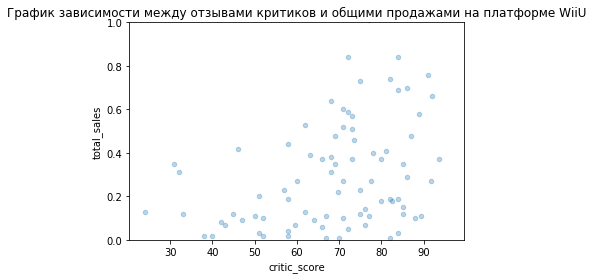


Коэффициент корреляции = 0.33



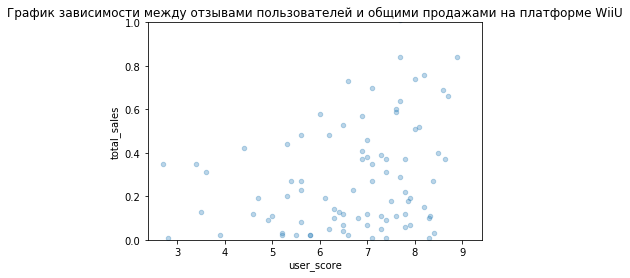


Коэффициент корреляции = 0.39
----------------------------------
Wii


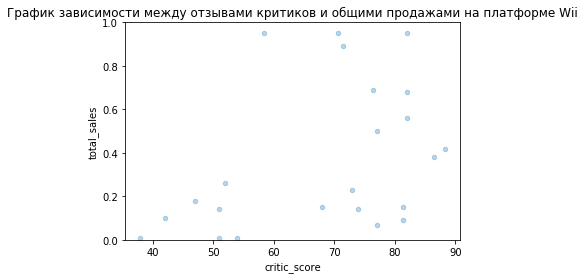


Коэффициент корреляции = 0.25



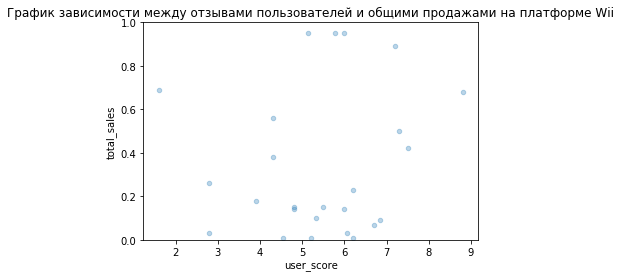


Коэффициент корреляции = 0.34
----------------------------------
PC


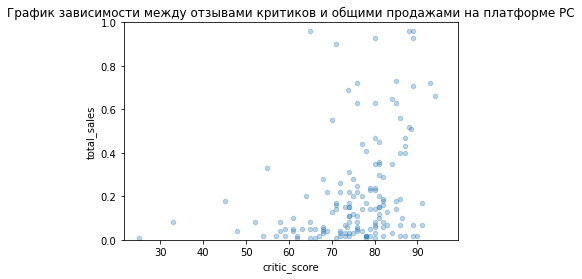


Коэффициент корреляции = 0.25



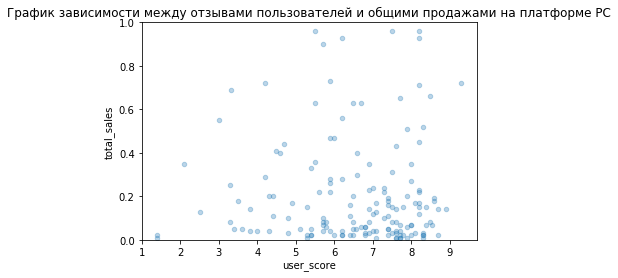


Коэффициент корреляции = -0.17
----------------------------------
PSV


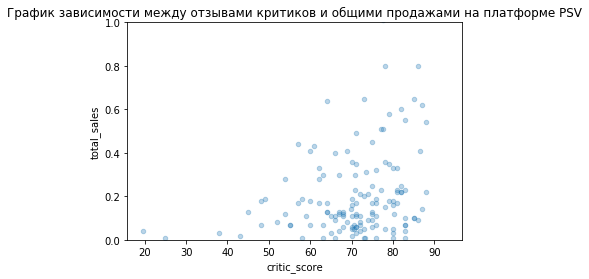


Коэффициент корреляции = 0.16



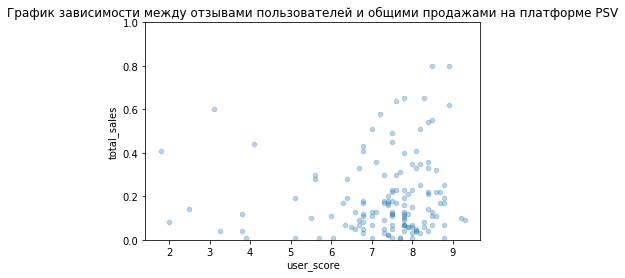


Коэффициент корреляции = 0.06
----------------------------------
PSP


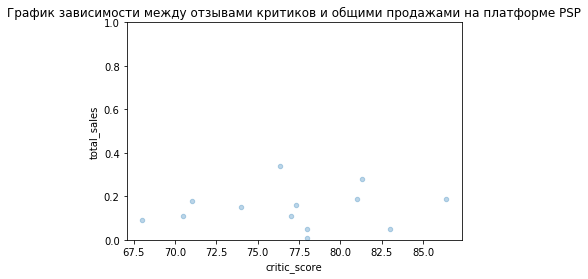


Коэффициент корреляции = 0.13



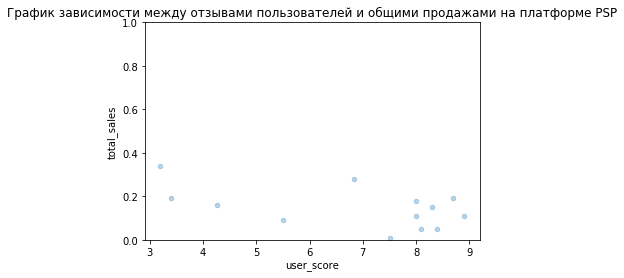


Коэффициент корреляции = -0.51
----------------------------------


In [36]:
platform_scatterplot(actual_df)

In [37]:
for name in actual_df['platform'].unique():
    print(name, len(actual_df[actual_df['platform'] == name])) 

PS3 455
X360 279
PS4 228
3DS 350
DS 31
XOne 160
WiiU 133
Wii 53
PC 196
PSV 326
PSP 173


#### Коэффиценты корреляций по всем платформам значительно различаются. Делать выводы, что в одной платформе наблюдается прямая связь, в другой обратная, а где-то связь вообще отсутствует, нельзя, потому что выборка данных очень маленькая, их размеры по каждой платформе сильно различаются, а в самом датафрейме еще имеется много пропущенных значений. 
#### Тем не менее, здравый смысл подсказывает, что между продажами и отзывами (как пользовательскими, так и от критиков) присутствует прямая связь, ведь люди перед покупкой чего-либо часто просматривают отзывы, и игры в этом плане не являются исключением. Поэтому лучше отталкиваться от того, что показывают графики рассеиваний. 

#### Графики рассеивания не показывают сильной прямой зависимости. Однако заметно, что на графиках платформ PS3, X360, PS4, 3DS, XOne, PC, WiiU, PSV точки с высокими значениями продаж расположены как правило по правую сторону графика - примерно начиная с значений user_score от 6 и critic_score от 60. Конечно же не все игры с рейтингом выше 6 (в случае с user_score) и 60 (в случае с critic_score) обязательно имеют большие продажи, но среди самых продаваемых игр чаще встречаются игры именно с таким высоким рейтингом

### Общее распределение игр по жанрам:

In [38]:
genres = actual_df.pivot_table(index= 'genre', values ='total_sales', aggfunc ={'count', 'sum'}).sort_values(by='sum', ascending = False)

genres['total_sales'] = genres['sum']
genres['amount_of_games'] = genres['count']
genres['sales_per_game'] = genres['sum'] / genres['count']

genres['amount_of_games_rank'] = genres['amount_of_games'].rank(method = 'dense', ascending = False)
genres['total_sales_rank'] = genres['total_sales'].rank(method = 'dense', ascending = False)
genres['sales_per_game_rank'] = genres['sales_per_game'].rank(method='dense', ascending = False)

genres = genres.drop(['count', 'sum'], axis = 1)
genres

,total_sales,amount_of_games,sales_per_game,amount_of_games_rank,total_sales_rank,sales_per_game_rank
genre,,,,,,
Action,411.01,853,0.481841,1.0,1.0,8.0
Shooter,266.51,188,1.417606,5.0,2.0,1.0
Role-Playing,174.62,316,0.552595,2.0,3.0,5.0
Sports,157.58,220,0.716273,4.0,4.0,3.0
Misc,82.44,160,0.515250,6.0,5.0,7.0
Platform,57.77,70,0.825286,9.0,6.0,2.0
Racing,50.71,91,0.557253,8.0,7.0,4.0
Fighting,40.02,93,0.430323,7.0,8.0,9.0
Simulation,33.23,62,0.535968,10.0,9.0,6.0


#### По каждому жанру было посчитано общие продажи, количество выпущенных игр, а также среднее значение продажи за игру. Для удобства были добавлены ранги - чем выше продажи, тем выше ранг (самому высокому соотвествует ранг 1, второму по продажам -  ранг 2 и т.д.)

In [39]:
genres.style.applymap(
    lambda x: 'background-color : lightgreen' if x<=3 
    else 'background-color : red' if x >= 10 #спасибо :) 
    else '',
    subset=['amount_of_games_rank', 'total_sales_rank', 'sales_per_game_rank'])

,total_sales,amount_of_games,sales_per_game,amount_of_games_rank,total_sales_rank,sales_per_game_rank
genre,,,,,,
Action,411.01,853,0.481841,1,1,8
Shooter,266.51,188,1.41761,5,2,1
Role-Playing,174.62,316,0.552595,2,3,5
Sports,157.58,220,0.716273,4,4,3
Misc,82.44,160,0.51525,6,5,7
Platform,57.77,70,0.825286,9,6,2
Racing,50.71,91,0.557253,8,7,4
Fighting,40.02,93,0.430323,7,8,9
Simulation,33.23,62,0.535968,10,9,6


#### Самые популярные жанры с точки зрения количества игр - Action, Role-playing и Adventure
#### Тремя жанрами с наибольшими продажами являются Action, Shooter и Role-playing
#### Так как высокие значения продаж могут достигаться просто за счет большого количества выпускаемых игр, был посчитан показатель средних продаж на игру. Здесь лидерами по прибыльности являются жанры Shooter, Platform и Sports. 

#### Жанр Adventure является одним из самых неуспешных с точки зрения продаж, так как игр выпускается большое количество, а денег с игр выручается мало. В этом же списке антилидеров по прибыльности присутствуют Strategy и Puzzle иры.

## Шаг 4. Составление портрета пользователя каждого региона 

### Самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP). Опишите различия в долях продаж.


In [40]:
na = actual_df.pivot_table(index='platform', values = 'na_sales', aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)
na['proportion'] = na['na_sales'] * 100 / na['na_sales'].sum()

eu = actual_df.pivot_table(index='platform', values = 'eu_sales', aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)
eu['proportion'] = eu['eu_sales'] * 100 / eu['eu_sales'].sum()

jp = actual_df.pivot_table(index='platform', values = 'jp_sales', aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)
jp['proportion'] = jp['jp_sales'] * 100 / jp['jp_sales'].sum()


In [41]:
display(na.head().round(2))
display(eu.head().round(2))
display(jp.head().round(2))

,platform,na_sales,proportion
9,X360,139.36,25.52
3,PS3,102.71,18.81
4,PS4,87.25,15.98
10,XOne,78.85,14.44
0,3DS,51.17,9.37


,platform,eu_sales,proportion
4,PS4,109.31,23.99
3,PS3,105.60,23.18
9,X360,73.81,16.20
10,XOne,41.96,9.21
0,3DS,40.31,8.85


,platform,jp_sales,proportion
0,3DS,79.76,46.03
3,PS3,33.99,19.62
6,PSV,17.48,10.09
8,WiiU,12.34,7.12
5,PSP,10.47,6.04


In [42]:
top5_na = na.nlargest(5, columns = 'na_sales') #отберем топ 5 платформ по каждому региону, все остальные платформы объединим в отдельную категорию
top5_eu = eu.nlargest(5, columns = 'eu_sales')
top5_jp= jp.nlargest(5, columns = 'jp_sales')

In [43]:
new_row_na = pd.DataFrame(data = {
    'platform' : ['others'],
    'na_sales' : [na['na_sales'][5:].sum()],
    'proportion' : [na['proportion'][5:].sum()]
})

new_row_eu = pd.DataFrame(data = {
    'platform' : ['others'],
    'eu_sales' : [eu['eu_sales'][5:].sum()],
    'proportion' : [eu['proportion'][5:].sum()]
})

new_row_jp = pd.DataFrame(data = {
    'platform' : ['others'],
    'jp_sales' : [jp['jp_sales'][5:].sum()],
    'proportion' : [jp['proportion'][5:].sum()]
})

In [44]:
top5_na = top5_na.append(new_row_na).set_index('platform').drop_duplicates()
top5_eu = top5_eu.append(new_row_eu).set_index('platform').drop_duplicates()
top5_jp = top5_jp.append(new_row_jp).set_index('platform').drop_duplicates()

In [45]:
display(top5_na)
display(top5_eu)
display(top5_jp)

,na_sales,proportion
platform,,
X360,139.36,25.521940
PS3,102.71,18.809977
PS4,87.25,15.978683
XOne,78.85,14.440334
3DS,51.17,9.371108
others,86.70,15.877958


,eu_sales,proportion
platform,,
PS4,109.31,23.992537
PS3,105.60,23.178227
X360,73.81,16.200615
XOne,41.96,9.209833
3DS,40.31,8.847673
others,84.61,18.571115


,jp_sales,proportion
platform,,
3DS,79.76,46.032204
PS3,33.99,19.616783
PSV,17.48,10.088301
WiiU,12.34,7.121833
PSP,10.47,6.042592
others,19.23,11.098286


In [46]:
display(top5_na.sum()) #проверка правильно ли произошло присоединение строк 'others' (сумма по столбцу proportion должна = 100)
display(top5_eu.sum())
top5_jp.sum()

na_sales      546.04
proportion    100.00
dtype: float64

eu_sales      455.6
proportion    100.0
dtype: float64

jp_sales      173.27
proportion    100.00
dtype: float64

Text(0.5, 1.0, 'Доли продаж игр на платформах в Японии')

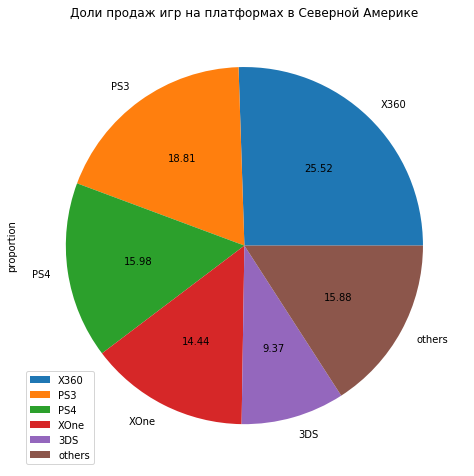

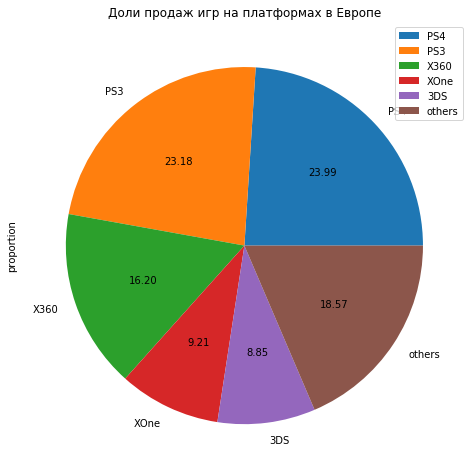

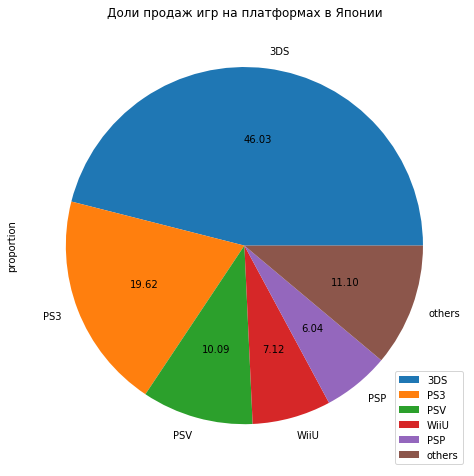

In [47]:
top5_na.plot.pie(y='proportion', figsize = (8,10), autopct='%.2f')
plt.title('Доли продаж игр на платформах в Северной Америке')

top5_eu.plot.pie(y='proportion', figsize = (8,10), autopct='%.2f')
plt.title('Доли продаж игр на платформах в Европе')

top5_jp.plot.pie(y='proportion', figsize = (8,10), autopct='%.2f')
plt.title('Доли продаж игр на платформах в Японии')

#### В Северной Америке (СА) наибольшей популярностью пользуются платформы X360, PS3 и PS4. 
#### В Европейском регионе зеркальная ситуация. На платформы PlayStation приходится почти половина рынка (47%), а  прочие платформы имеют почти 20% в общей доле продаж. 
#### В Японии каждая платформа из топ 5 является отечественной. На эти платформы приходиться почти весь рынок.

### Самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP). Поясните разницу


In [48]:
display(actual_df.pivot_table(index='genre', values = 'na_sales', aggfunc='sum').sort_values(by='na_sales',ascending=False).head())
display(actual_df.pivot_table(index='genre', values = 'eu_sales', aggfunc='sum').sort_values(by='eu_sales',ascending=False).head())
display(actual_df.pivot_table(index='genre', values = 'jp_sales', aggfunc='sum').sort_values(by='jp_sales',ascending=False).head())

,na_sales
genre,
Action,168.55
Shooter,128.53
Sports,73.99
Role-Playing,58.11
Misc,37.43


,eu_sales
genre,
Action,148.66
Shooter,97.57
Sports,57.08
Role-Playing,44.25
Misc,25.66


,jp_sales
genre,
Role-Playing,58.83
Action,45.73
Misc,11.82
Simulation,10.08
Fighting,8.69


#### Список самых популярных игровых жанров в СА совпадает с Европой и разительно отличается с Японией.   
#### В отличие от западных стран, в Японии более популярны жанры Role-Playing, Simulation и Fighting. Возможно это связано с особенностями жителей Японии. Достаточно известный факт, что одиночество - одна из самых насущных проблем среди японцев, жанры Role-Playing и Simulation возможно поэтому пользуются большой популярностью. Жанр Fighting может быть связан с популярностью восточных единоборств в целом в странах Восточной Азии  

### Влияет ли рейтинг ESRB на продажи в отдельном регионе (NA, EU, JP)?

In [49]:
display(actual_df.pivot_table(index='rating', values = 'na_sales', aggfunc='sum').sort_values(by='na_sales',ascending=False).head())
display(actual_df.pivot_table(index='rating', values = 'eu_sales', aggfunc='sum').sort_values(by='eu_sales',ascending=False).head())
display(actual_df.pivot_table(index='rating', values = 'jp_sales', aggfunc='sum').sort_values(by='jp_sales',ascending=False).head())

,na_sales
rating,
M,221.74
E,109.79
E10+,74.03
T,60.20


,eu_sales
rating,
M,183.42
E,101.71
E10+,54.08
T,46.65


,jp_sales
rating,
E,28.17
T,26.08
M,20.74
E10+,8.12


#### В СА и Европе наиболее прибыльные игры с рейтингом M (для взрослых от 17 лет) и E (для игроков любого возраста). 
#### В Японии выделяются рейтинги E, T (для подростков от 13 лет) и M. 
#### Стоит также отметить, что в Японии все три возрастных рейтинга в плане продаж не сильно отличаются друг от друга, в то время как в Северной Америке и Европе видна существенная разница между самыми "продаваемыми" возрастными категориями
 
#### Скорее всего прибыльность игр категории M связана с аудиторией, на которую эти игры направлены: взрослые люди более платежеспособны чем подростки, таким образом они готовы платить деньги за игры. 

## Шаг 5. Проверьте гипотезы

**Гипотеза H0**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Гипотеза H1**: Средние пользовательские рейтинги платформ Xbox One и PC неодинаковые

In [50]:
xbox = actual_df[actual_df['platform'] == 'XOne']
pc = actual_df[actual_df['platform'] == 'PC']

In [51]:
print('Дисперсия пользовательских рейтингов платформы Xbox One', xbox['user_score'].var())
print('Дисперсия пользовательских рейтингов платформы PC', pc['user_score'].var())

Дисперсия пользовательских рейтингов платформы Xbox One 1.7151245598478424
Дисперсия пользовательских рейтингов платформы PC 2.744216155046399


In [52]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(xbox['user_score'].dropna(), pc['user_score'].dropna(), equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.652403100834139
Не получилось отвергнуть нулевую гипотезу


#### Гипотеза о равенстве средних пользовательских оценок платформ Xbox One и PC не отвергнута.
-----------

**Гипотеза H0**: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

**Гипотеза H1** : Средние пользовательские рейтинги жанров Action и Sports разные.


In [53]:
action = actual_df[actual_df['genre'] == 'Action']
sports = actual_df[actual_df['genre'] == 'Sports']

In [54]:
print('Дисперсия пользовательских рейтингов жанра Action', action['user_score'].var())
print('Дисперсия пользовательских рейтингов платформы Sports', sports['user_score'].var())

Дисперсия пользовательских рейтингов жанра Action 1.8648649114577671
Дисперсия пользовательских рейтингов платформы Sports 2.6729549273690707


In [55]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(action['user_score'].dropna(), sports['user_score'].dropna(), equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.040333560306864e-23
Отвергаем нулевую гипотезу


#### Гипотеза о равенстве средних пользовательских оценок жанров Action и Sports отвергнута.
-----------

## Шаг 6. Общий вывод

На первом этапе работы был изучена общая информация по датафрейму: рассмотрены типы данных в столбцах, содержащиеся в них количество пропусков.

-------------------
Далее была произведена предобработка данных. Она включала в себя изменение названия столбцов, преобразование типов данных и заполнение пропусков (там, где это было возможно). Также был добавлен новый столбец в таблицу 'total_sales', отражающий суммарные продажи всех регионов.

-------------------
На третьем этапе был сделан большой срез данных. Как показывали графики, ситуация на рынке меняется каждые 5 лет в связи с уходом старых и приходом новых платформ. Было принято решение использовать данные по продажам с 2012 по 2015 годы включительно, так как до 2012 г. продажи игр стремительно падали, а с 2012 г. ситуация стабилизировалась и для прогнозирования продаж на 2017 г. пятилетний период как раз будет подходить лучше всего. 

Самыми прибыльными платформами являются  PS3, PS4, X360, 3DS, XOne. Наблюдение подтверждают графики "ящик с усами". Из всех платформ лишь у PS4 и XOne имеется возрастающий тренд. 

Отзывы пользователей и критиков на продажи не зависит от платформы. По большинству платформ замечено, что игры с высокими продажами обязательно имеют высокие рейтинги, однако высокий рейтинг сам по себе не гарантия высоких продаж.   

Самые популярные жанры с точки зрения количества выпускаемых игр - Action, Role-playing и Adventure
Тремя жанрами с наибольшими продажами являются Action, Shooter и Role-playing
Тремя жанрами с наименьшими продажами являются Adventure, Strategy и Puzzle

----------------------
Для каждого региона (NA, EU, JP) были определены самые популярные платформы. 
#### NA:   
1) X360             

2) PS3	

3) PS4	

4) XOne

5) 3DS

#### EU: 

1) PS4

2) PS3	

3) X360

4) XOne

5) 3DS	

#### JP:

1) 3DS	


2) PS3	

3) PSV	

4) WiiU

5) PSP

Стоит отметить, что в Японии все платформы отечественного производства. 

#### Самые популярные жанры в NA, EU:  

1) Action

2) Shooter

3) Sports

4) Role-Playing

5) Misc	

#### Самые популярные жанры в  JP: 

1) Role-Playing	
2) Action	
3) Misc	
4) Simulation	
5) Fighting


Наиболее прибыльными возрастными рейтингами являются 'M', 'E', 'T'. Тем не менее, считать, что рейтинг не влияет на продажи некорректно. 

--------------
Наконец, были проверены две гипотезы: 

1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

2) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверок был использован метод **ttest_ind**, так как проверялось равенство средних двух генеральных совокупностей


По итогам расчетов обе гипотезы не были отвергнуты.